In [20]:
# %% ========================================
# 0. ライブラリ & データ読み込み
# ========================================
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 02_feature_engineering の出力を読み込み
DAILY_PATH = "/home/jovyan/work/data/interim/df_daily.parquet"
df_daily = pd.read_parquet(DAILY_PATH)
print(f"✅ Loaded df_daily: {df_daily.shape[0]} rows, {df_daily['athlete_name'].nunique()} athletes")


✅ Loaded df_daily: 16499 rows, 57 athletes


In [21]:
# %% ========================================
# 1. データ量が最も多い選手を選定
# ========================================
top_player = (
    df_daily.groupby("athlete_name")["date_"]
    .nunique()
    .sort_values(ascending=False)
    .index[0]
)

df_focus = df_daily[df_daily["athlete_name"] == top_player].copy()
print(f"🎯 対象選手: {top_player}")
print(f"📅 データ日数: {df_focus['date_'].nunique()} 日")

🎯 対象選手: Kaoru YAMAWAKI
📅 データ日数: 623 日


In [22]:
features = [
    "ACWR_EWMA_total_distance", "EWMA7_total_distance", "EWMA28_total_distance", "EWMA_ratio_total_distance",
    "ACWR_EWMA_total_player_load", "EWMA7_total_player_load", "EWMA28_total_player_load", "EWMA_ratio_total_player_load"
]

# 欠損除去
df_focus_model = df_focus.dropna(subset=features).copy()

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# 標準化
X_scaled = StandardScaler().fit_transform(df_focus_model[features])

# モデル適用
model = IsolationForest(contamination=0.05, random_state=42)
df_focus_model["anomaly_score"] = model.fit_predict(X_scaled)
df_focus_model["is_anomaly"] = df_focus_model["anomaly_score"] == -1


=== Detection summary ===
days_used: 595
anomaly_days: 30
anomaly_ratio: 0.05042016806722689
date_range: (Timestamp('2023-02-22 00:00:00'), Timestamp('2025-10-05 00:00:00'))


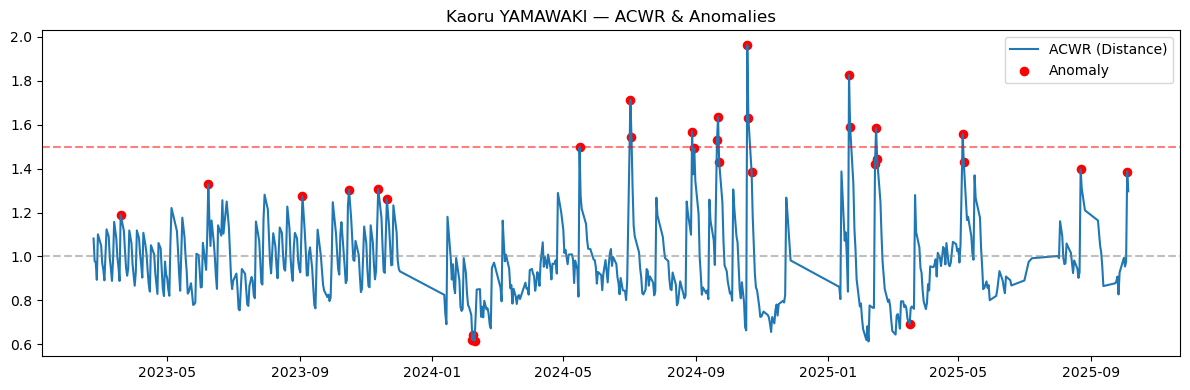

In [23]:
# 検出サマリー
summary = {
    "days_used": int(len(df_focus_model)),
    "anomaly_days": int(df_focus_model["is_anomaly"].sum()),
    "anomaly_ratio": float(df_focus_model["is_anomaly"].mean()),
    "date_range": (df_focus_model["date_"].min(), df_focus_model["date_"].max()),
}
print("=== Detection summary ===")
for k,v in summary.items():
    print(f"{k}: {v}")

# 週別の異常率
weekly = (
    df_focus_model
    .assign(week=lambda d: d["date_"].dt.to_period("W").dt.start_time)
    .groupby("week")["is_anomaly"]
    .mean()
    .reset_index()
    .rename(columns={"is_anomaly":"anomaly_rate"})
)

# 可視化：ACWRと異常マーカー
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df_focus_model["date_"], df_focus_model["ACWR_EWMA_total_distance"], label="ACWR (Distance)")
plt.scatter(
    df_focus_model.loc[df_focus_model["is_anomaly"], "date_"],
    df_focus_model.loc[df_focus_model["is_anomaly"], "ACWR_EWMA_total_distance"],
    s=35, color="red", label="Anomaly"
)
plt.axhline(1.5, color="red", ls="--", alpha=0.5)
plt.axhline(1.0, color="gray", ls="--", alpha=0.5)
plt.title(f"{top_player} — ACWR & Anomalies")
plt.legend(); plt.tight_layout(); plt.show()


In [24]:
df_focus_model["high_acwr"] = df_focus_model["ACWR_EWMA_total_distance"] > 1.5

ct = pd.crosstab(df_focus_model["is_anomaly"], df_focus_model["high_acwr"],
                 rownames=["Anomaly"], colnames=["ACWR>1.5"])
print("\n=== Cross-tab: Anomaly vs ACWR>1.5 ===")
print(ct)

# 簡易指標：Jaccard（異常集合とACWR>1.5集合の重なり）
anomaly_set = set(df_focus_model.index[df_focus_model["is_anomaly"]])
highacwr_set = set(df_focus_model.index[df_focus_model["high_acwr"]])
jaccard = len(anomaly_set & highacwr_set) / max(1, len(anomaly_set | highacwr_set))
print(f"Jaccard overlap = {jaccard:.3f}")



=== Cross-tab: Anomaly vs ACWR>1.5 ===
ACWR>1.5  False  True 
Anomaly               
False       565      0
True         19     11
Jaccard overlap = 0.367



=== Normal days summary ===


,mean,std,min,25%,50%,75%,max
ACWR_EWMA_total_distance,0.950,0.144,0.614,0.848,0.939,1.036,1.387
EWMA7_total_distance,1846.458,817.679,772.314,1101.253,1595.614,2510.484,3939.844
EWMA28_total_distance,1921.519,734.691,989.683,1245.352,1625.367,2641.805,3300.059
EWMA_ratio_total_distance,0.950,0.144,0.614,0.848,0.939,1.036,1.387
ACWR_EWMA_total_player_load,0.953,0.139,0.667,0.850,0.937,1.036,1.399
EWMA7_total_player_load,198.006,89.080,86.479,117.621,168.131,271.991,409.540
EWMA28_total_player_load,205.265,80.390,106.341,134.805,166.318,286.864,353.166
EWMA_ratio_total_player_load,0.953,0.139,0.667,0.850,0.937,1.036,1.399



=== Anomaly days summary ===


,mean,std,min,25%,50%,75%,max
ACWR_EWMA_total_distance,1.375,0.335,0.617,1.304,1.430,1.565,1.961
EWMA7_total_distance,2790.550,1028.502,748.935,2071.812,2787.483,3785.043,4929.701
EWMA28_total_distance,2028.466,606.846,1082.659,1559.383,1947.060,2374.965,3333.332
EWMA_ratio_total_distance,1.375,0.335,0.617,1.304,1.430,1.565,1.961
ACWR_EWMA_total_player_load,1.344,0.307,0.622,1.292,1.430,1.552,1.720
EWMA7_total_player_load,278.682,97.038,83.791,223.548,276.852,338.126,430.863
EWMA28_total_player_load,208.745,65.569,116.078,168.359,199.357,210.715,347.764
EWMA_ratio_total_player_load,1.344,0.307,0.622,1.292,1.430,1.552,1.720


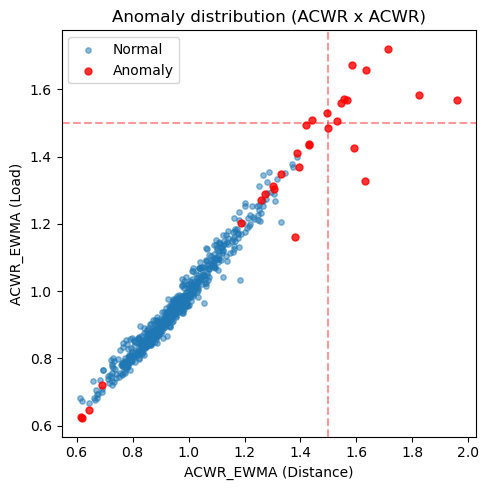

In [25]:
features = [
    "ACWR_EWMA_total_distance","EWMA7_total_distance","EWMA28_total_distance","EWMA_ratio_total_distance",
    "ACWR_EWMA_total_player_load","EWMA7_total_player_load","EWMA28_total_player_load","EWMA_ratio_total_player_load",
]
norm = df_focus_model.loc[~df_focus_model["is_anomaly"], features]
anom = df_focus_model.loc[df_focus_model["is_anomaly"], features]

desc_norm = norm.describe().T[["mean","std","min","25%","50%","75%","max"]]
desc_anom = anom.describe().T[["mean","std","min","25%","50%","75%","max"]]

print("\n=== Normal days summary ===")
display(desc_norm.round(3))
print("\n=== Anomaly days summary ===")
display(desc_anom.round(3))

# 2軸散布：距離系×負荷系のACWR
plt.figure(figsize=(5,5))
plt.scatter(norm["ACWR_EWMA_total_distance"], norm["ACWR_EWMA_total_player_load"], s=15, alpha=0.5, label="Normal")
plt.scatter(anom["ACWR_EWMA_total_distance"], anom["ACWR_EWMA_total_player_load"], s=25, alpha=0.8, label="Anomaly", color="red")
plt.axvline(1.5, color="red", ls="--", alpha=0.4)
plt.axhline(1.5, color="red", ls="--", alpha=0.4)
plt.xlabel("ACWR_EWMA (Distance)"); plt.ylabel("ACWR_EWMA (Load)")
plt.title("Anomaly distribution (ACWR x ACWR)")
plt.legend(); plt.tight_layout(); plt.show()


In [26]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

X = df_focus_model[features].values
y = df_focus_model["is_anomaly"].astype(int).values  # 0/1に

# 既存のIsolationForest出力をそのまま使うため、学習済み model を用いたスコア関数でPI
scaler = StandardScaler().fit(df_focus_model[features])
X_scaled = scaler.transform(df_focus_model[features])

def score_func(estimator, Xv, yv):
    # 異常かどうかの一致率（擬似目的）
    pred = (estimator.predict(Xv) == -1).astype(int)
    return (pred == yv).mean()

pi = permutation_importance(model, X_scaled, y, scoring=score_func, n_repeats=20, random_state=42)
imp = pd.DataFrame({"feature": features, "importance": pi.importances_mean}).sort_values("importance", ascending=False)
print("\n=== Permutation importance (proxy) ===")
display(imp)



=== Permutation importance (proxy) ===


,feature,importance
2,EWMA28_total_distance,0.022437
6,EWMA28_total_player_load,0.019580
5,EWMA7_total_player_load,0.018235
1,EWMA7_total_distance,0.018151
3,EWMA_ratio_total_distance,0.012857
4,ACWR_EWMA_total_player_load,0.012101
0,ACWR_EWMA_total_distance,0.011345
7,EWMA_ratio_total_player_load,0.010756


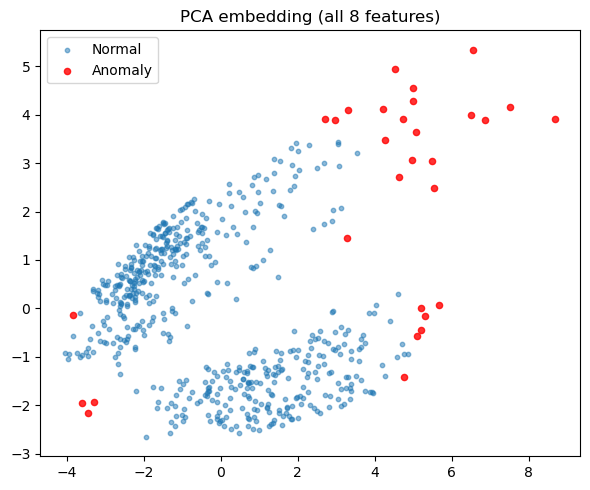

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
emb = pca.fit_transform(X_scaled)
df_emb = df_focus_model.copy()
df_emb["pc1"] = emb[:,0]; df_emb["pc2"] = emb[:,1]

plt.figure(figsize=(6,5))
plt.scatter(df_emb.loc[~df_emb["is_anomaly"], "pc1"],
            df_emb.loc[~df_emb["is_anomaly"], "pc2"], s=10, alpha=0.5, label="Normal")
plt.scatter(df_emb.loc[df_emb["is_anomaly"], "pc1"],
            df_emb.loc[df_emb["is_anomaly"], "pc2"], s=20, alpha=0.8, color="red", label="Anomaly")
plt.title("PCA embedding (all 8 features)"); plt.legend(); plt.tight_layout(); plt.show()


In [28]:
from sklearn.metrics import jaccard_score

conts = [0.02, 0.05, 0.08, 0.10, 0.15]
jaccards = []
pred_sets = []

for c in conts:
    m = IsolationForest(contamination=c, random_state=42).fit(X_scaled)
    pred = (m.predict(X_scaled) == -1).astype(int)
    pred_sets.append(pred)

# 0.05 を基準にJaccardで安定性を計測
base = pred_sets[1]
for i, pred in enumerate(pred_sets):
    j = jaccard_score(base, pred)
    jaccards.append(j)

stab = pd.DataFrame({"contamination": conts, "jaccard_vs_0.05": jaccards})
print("\n=== Stability vs contamination ===")
display(stab)



=== Stability vs contamination ===


,contamination,jaccard_vs_0.05
0,0.02,0.400000
1,0.05,1.000000
2,0.08,0.625000
3,0.10,0.500000
4,0.15,0.333333


In [29]:
!pip uninstall -y typing_extensions
!pip install typing_extensions==4.12.2


Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)


In [30]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: torch 2.9.0+cpu
Uninstalling torch-2.9.0+cpu:
  Successfully uninstalled torch-2.9.0+cpu
Found existing installation: torchvision 0.24.0+cpu
Uninstalling torchvision-0.24.0+cpu:
  Successfully uninstalled torchvision-0.24.0+cpu
Found existing installation: torchaudio 2.9.0+cpu
Uninstalling torchaudio-2.9.0+cpu:
  Successfully uninstalled torchaudio-2.9.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.9.0%2Bcpu-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.24.0%2Bcpu-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.9.0%2Bcpu-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.9.0%2Bcpu-cp311-cp311-manylinux_2_28_x86_64.whl (184.5 MB)
Using cached https://download.pytorch.org/whl/c

In [31]:
import torch
import typing_extensions
print("✅ torch:", torch.__version__)
print("💻 Device available:", "GPU" if torch.cuda.is_available() else "CPU only")


✅ torch: 2.9.0+cpu
💻 Device available: CPU only


Epoch 0: loss=1.0099
Epoch 10: loss=0.5205
Epoch 20: loss=0.4442
Epoch 30: loss=0.4133
Epoch 40: loss=0.3866
⚠️ dynamic anomalies detected: 29


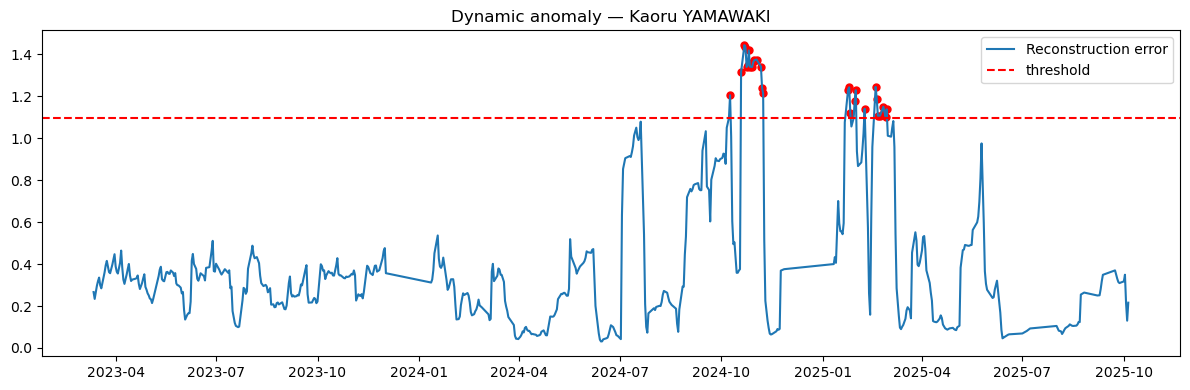

In [32]:
# ============================================
# LSTM Autoencoderによる動的異常検知
# ============================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# データ読み込み（02_feature_engineering の出力）
df_daily = pd.read_parquet("/home/jovyan/work/data/interim/df_daily.parquet")

# 対象選手を指定
player = "Kaoru YAMAWAKI"
df = df_daily[df_daily["athlete_name"] == player].dropna().sort_values("date_")

# 特徴量選択
features = [
    "ACWR_EWMA_total_distance","EWMA_ratio_total_distance",
    "ACWR_EWMA_total_player_load","EWMA_ratio_total_player_load",
    "EWMA7_total_distance","EWMA7_total_player_load",
    "EWMA28_total_distance","EWMA28_total_player_load"
]

X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# データセット定義
SEQ_LEN = 14  # 14日間を1ウィンドウ
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len=14):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        seq = self.data[idx:idx+self.seq_len]
        return seq, seq

dataset = SequenceDataset(X_scaled, seq_len=SEQ_LEN)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# モデル定義
class LSTMAE(nn.Module):
    def __init__(self, n_features, latent_dim=16):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=latent_dim, batch_first=True)
        self.decoder = nn.LSTM(input_size=latent_dim, hidden_size=n_features, batch_first=True)
    def forward(self, x):
        _, (h, _) = self.encoder(x)
        h = h.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        out, _ = self.decoder(h)
        return out

# モデル初期化
device = torch.device("cpu")
model = LSTMAE(n_features=len(features), latent_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 学習
EPOCHS = 50
for epoch in range(EPOCHS):
    losses = []
    for seq, target in loader:
        seq, target = seq.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(seq)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={np.mean(losses):.4f}")

# 再構成誤差を算出
model.eval()
recon_errors = []
with torch.no_grad():
    for i in range(len(X_scaled) - SEQ_LEN):
        seq = torch.tensor(X_scaled[i:i+SEQ_LEN], dtype=torch.float32).unsqueeze(0).to(device)
        recon = model(seq).squeeze(0).cpu().numpy()
        error = np.mean((X_scaled[i:i+SEQ_LEN] - recon)**2)
        recon_errors.append(error)


# DataFrame化
df_score = df.iloc[SEQ_LEN:].copy()
df_score["recon_error"] = recon_errors

# 閾値設定（95パーセンタイル）
threshold = np.percentile(df_score["recon_error"], 95)
df_score["is_anomaly_dyn"] = df_score["recon_error"] > threshold
print(f"⚠️ dynamic anomalies detected: {df_score['is_anomaly_dyn'].sum()}")

# 可視化
plt.figure(figsize=(12,4))
plt.plot(df_score["date_"], df_score["recon_error"], label="Reconstruction error")
plt.axhline(threshold, color="red", linestyle="--", label="threshold")
plt.scatter(df_score.loc[df_score["is_anomaly_dyn"], "date_"],
            df_score.loc[df_score["is_anomaly_dyn"], "recon_error"],
            color="red", s=25)
plt.legend(); plt.title(f"Dynamic anomaly — {player}"); plt.tight_layout(); plt.show()
